In [ ]:
%load_ext autoreload
%autoreload 2

In [43]:
# Import Modules
import ast
import pandas as pd
from pandas_profiling import ProfileReport
import plotly.express as px
plotly_themes = ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]


import surprise
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy

from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise.model_selection import cross_validate
from surprise import KNNBaseline
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

import matplotlib.pyplot as plt
import mplcyberpunk
%matplotlib inline

plt.style.use('ggplot')
# plt.style.use("cyberpunk")

import os
os.getcwd()

'/home/jovyan/work/Capstone_3/Skincare-Recommender'

In [44]:
# Import Custom Modules
from src.helpers import *

In [4]:
# Import Data
items = pd.read_csv('data/item_df.csv')
users = pd.read_csv('data/user_df.csv')
chemicals = pd.read_csv('data/chemical_effects.csv')

# Make Changes to ingredients to be evaluated as list
items['ingredients'] = items['ingredients'].apply(ast.literal_eval)
users.drop(users.columns[0], axis=1, inplace=True)
items.drop(items.columns[0], axis=1, inplace=True)

In [5]:
# # Only parse out needed features
# users_truncate = users[['user_id', 'item_name', 'star_rating']]

# users_truncate.head()

In [32]:
# items['ingredients']
items.head()

,item_url,item_brand,item_name,n_loves,avg_stars,n_reviews,five_stars,four_stars,three_stars,two_stars,...,oily,sensitive,moisture,antioxidant,soothing,irritancy,brightening,viscosity,cleaning,fragrance
0,https://www.sephora.com/product/protini-tm-pol...,brand_1,item_1,259473,4.0,4395,2557,540,402,405,...,1,0,9,2,0,1,1,1,2,0
1,https://www.sephora.com/product/the-water-crea...,brand_2,item_2,233187,4.0,3030,1817,392,307,232,...,1,1,7,2,0,1,1,2,0,0
2,https://www.sephora.com/product/the-true-cream...,brand_3,item_3,191092,4.5,4527,3276,665,246,173,...,1,0,5,1,0,0,0,5,1,2
3,https://www.sephora.com/product/cactus-water-m...,brand_4,item_4,26641,4.0,2221,1263,538,178,108,...,1,0,3,3,0,0,1,1,0,0
4,https://www.sephora.com/product/dramatically-d...,brand_5,item_5,80124,4.5,2619,1721,565,151,85,...,1,1,4,0,0,0,0,2,0,0


# User Visualizations

### Distribution of Meta Data

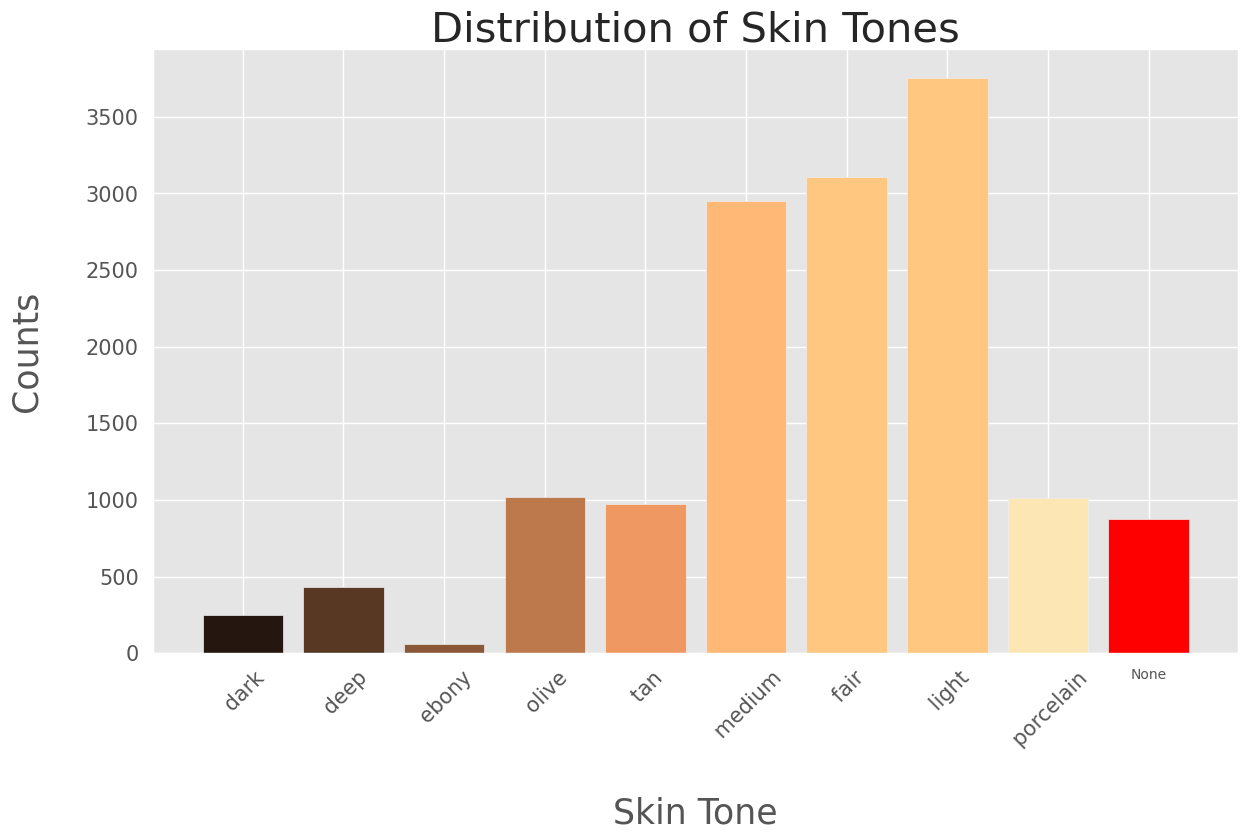

In [7]:
# Get Skin Tone Counts
skin_tones = users.groupby('skin_tone')['user_id'].count().reindex(index = [
    ' dark',
    ' deep',
    ' ebony',
    ' olive',
    ' tan',
    ' medium',
    ' fair',
    ' light',
    ' porcelain',
    'None'
])

# Looking at Skin Type
fig, ax = plt.subplots(figsize=(14, 8), dpi=100)

# Create Skin Tone Color Map
# skin_color = dict(zip(skin_tones.index.tolist(), ))

sizes = np.linspace(5, 20, num=50)
theme = plt.get_cmap('copper')
tones = [theme(2 * i / len(sizes)) for i in range(len(sizes))][3::4]
tones[8] = (0.99, 0.90, 0.7, 1.0)
tones[9] = 'red'

ax.bar(skin_tones.index, skin_tones.values, color=tones)

ax.set_title('Distribution of Skin Tones', fontsize=30)
ax.set_xlabel('Skin Tone', fontsize=25, labelpad=30)
ax.set_ylabel('Counts', fontsize=25, labelpad=30)

for xtick, ytick in zip(ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()):
    xtick.label.set_fontsize(15) 
    xtick.label.set_rotation(45)
    
    ytick.label.set_fontsize(15) 
#     xtick.label.set_rotation(45)


# mplcyberpunk.add_glow_effects()
# mplcyberpunk.add_underglow()

fig.show()

In [30]:
fig = px.bar(x=skin_tones.index, y=skin_tones.values, color=tones[:10], title='Distribution of Skin Tones')

fig.update_layout(showlegend=False)

fig.show()

fig.write_html("plotly/skin_tone_counts_bar.html")

# Item Visualizations

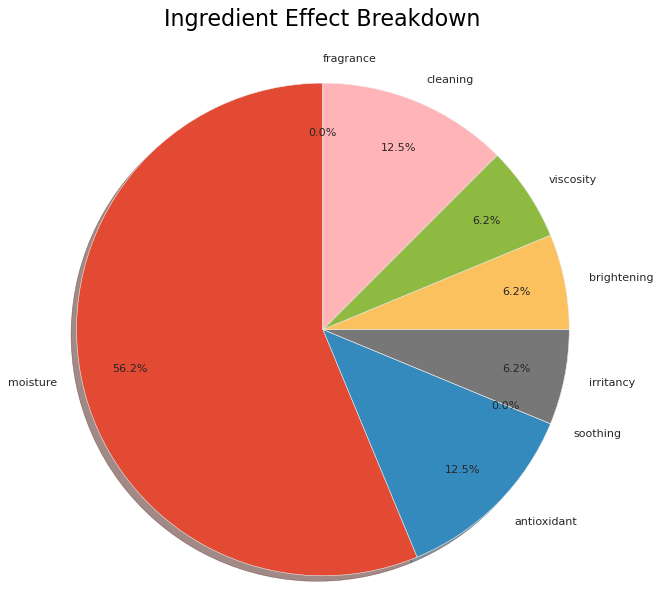

['moisture', 'antioxidant', 'soothing', 'irritancy', 'brightening', 'viscosity', 'cleaning', 'fragrance']
[9, 2, 0, 1, 1, 1, 2, 0]


In [9]:
# plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 9), dpi=80)
# fig = px.pie(items.iloc[0, 19:], title='Ingredient Effects')
# fig.show()

wedges, labels, autopct = ax.pie(items.iloc[0, 19:], labels=items.columns.tolist()[19:], autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.8, )

for lab in labels:
    lab.set_fontsize(10)
    
ax.axis('equal')
    
ax.set_title('Ingredient Effect Breakdown', pad=30, size=20, color='black')

plt.show()


print(items.columns.tolist()[19:])
print(items.iloc[0, 19:].tolist())

In [42]:
cur_title = f'DRUNK ELEPHANT: Protini Polypeptide Moisturizer Ingredient Effects'
fig = px.pie(values=items.iloc[0, 19:], names=items.columns.tolist()[19:], title=cur_title)
fig.show()

fig.write_html("plotly/ingredient_effect_1.html")

0     item_1
1     item_2
2     item_3
3     item_4
4     item_5
5     item_6
6     item_7
7     item_8
8     item_9
9    item_10
Name: item_name, dtype: object

# NLP Featurizations

In [66]:
# Import Needed NLP Modules
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Load the LDA model from sk-learn
# from sklearn.decomposition import LatentDirichletAllocation as LDA
# from pyLDAvis import sklearn as sklearn_lda
# import pyLDAvis

# NLTK Modules
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')
from nltk import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import chunk
from nltk.util import ngrams

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /home/jovyan/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [12]:
# Featurize review section for users dataframe

stops = stopwords.words('english')
# Split and lowercase all tokens
reviews = users['review'].apply(lambda x: [i.lower() for i in x.split(' ') if i.lower() not in stops])
reviews = reviews.apply(lambda line: [re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem) for elem in line])
users['review'] = reviews
cleaned_reviews = 0

In [13]:
# Create Review Groups from Users Dataframe
item_one = users[users['item_name'] == 'item_1']
item_two = users[users['item_name'] == 'item_2']
item_three = users[users['item_name'] == 'item_3']
item_four = users[users['item_name'] == 'item_4']
item_five = users[users['item_name'] == 'item_5']
item_six = users[users['item_name'] == 'item_6']
item_seven = users[users['item_name'] == 'item_7']
item_eight = users[users['item_name'] == 'item_8']
item_nine = users[users['item_name'] == 'item_9']
item_ten = users[users['item_name'] == 'item_10']

item_one_reviews = item_one['review']
item_two_reviews = item_two['review']
item_three_reviews = item_three['review']
item_four_reviews = item_four['review']
item_five_reviews = item_five['review']
item_six_reviews = item_six['review']
item_seven_reviews = item_seven['review']
item_eight_reviews = item_eight['review']
item_nine_reviews = item_nine['review']
item_ten_reviews = item_ten['review']

In [14]:
# Create Porter, Snowball, WordNet Objects
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()
lancaster = LancasterStemmer()


# Get functions from each object
porter_func = porter.stem
snowball_func = snowball.stem
wordnet_func = wordnet.lemmatize
lancaster_func = lancaster.stem


# Create lambda func to easily apply func to each token
get_root = lambda tokens, func: [func(token) for token in tokens]

In [15]:
# Get Tokens for each type of processor
# porter_tokens = users['review'].apply(lambda x: get_root(x, porter_func)) 
snowball_tokens = users['review'].apply(lambda x: get_root(x, snowball_func)) 
# wordnet_tokens = users['review'].apply(lambda x: get_root(x, wordnet_func))
# lancaster_tokens = users['review'].apply(lambda x: get_root(x, lancaster_func))

In [16]:
# rev_num = 5
# # Print the stemmed and lemmatized words from the target document
# print("%16s | %16s | %16s | %16s | %16s |" % ("WORD", "PORTER", "SNOWBALL", "WN-LEMMATIZER", "LANCASTER"))
# for i in range(min(len(porter_tokens[rev_num]), len(snowball_tokens[rev_num]), len(wordnet_tokens[rev_num]), len(lancaster_tokens[rev_num]))):
#     p, s, w, l = porter_tokens[rev_num][i], snowball_tokens[rev_num][i], wordnet_tokens[rev_num][i], lancaster_tokens[rev_num][i]
#     if len(set((p, s, w, l))) != 1:
#         print("%16s | %16s | %16s | %16s | %16s |" % (users['review'][rev_num][i], p, s, w, l))

In [17]:
# Choose Snowball Stemmer
users['stem_review'] = snowball_tokens

# NLP Visualizations

In [18]:


def generate_wordcloud(data):
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(data)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()



# Targeting Skin Condtions

In [49]:
# Create skin condition features
skin_conditions = ['eczema', 'psoriasis', 'allergic', 'rosacea', 'acne', 'breakout', 'hives', 'itchiness']
# Skin Condition List used for Regex Match Flag
re_sc = ['ecze', 'psori', 'allerg', 'rosac', 'acne', 'breakou', 'hive', 'itch']

# Create Flags for Skin Conditions
users['flag_skin_condition'] = users['review'].apply(lambda x: flag_condition(x, re_sc))

In [52]:
users.head()

,user_id,star_rating,review,item_brand,item_name,age,eye_color,hair_color,skin_tone,skin_type,timestamp,verified,is_positive,stem_review,flag_skin_condition
0,0,5,"[moisturizer, worked, really, well, skin, comb...",brand_1,item_1,None,brown,black,medium,oily,2020-06-04 21:00:00,0,1,"[moistur, work, realli, well, skin, combo, ski...",0
1,1,2,"[soooo, first, started, using, this, broke, re...",brand_1,item_1,None,hazel,brunette,medium,dry,2020-06-04 10:00:00,0,0,"[soooo, first, start, use, this, broke, realli...",0
2,2,4,"[goto, moisturizer, dry, skin, healing, acne, ...",brand_1,item_1,None,brown,black,medium,combination,2020-06-04 09:00:00,0,1,"[goto, moistur, dri, skin, heal, acn, never, l...",1
3,3,2,"[got, part, birthday, gift, used, faceneck, ev...",brand_1,item_1,NaN,NaN,NaN,NaN,NaN,2020-06-04 09:00:00,0,0,"[got, part, birthday, gift, use, faceneck, eve...",1
4,4,2,"[alright, bought, loved, trial, birthday, gift...",brand_1,item_1,None,blue,blonde,fair,normal,2020-06-04 00:00:00,0,0,"[alright, bought, love, trial, birthday, gift,...",0


# Word Clouds

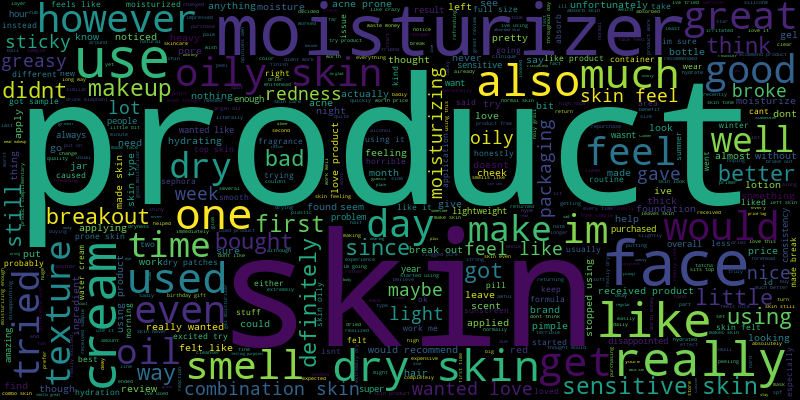

In [71]:
negative_reviews = users[users['is_positive'] == 0]
negatives = " ".join([" ".join(review) for review in negative_reviews['review']])

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=500, contour_width=3,  width=800, height=400, stopwords=stops)

# Generate a word cloud
wordcloud.generate(negatives)

# Visualize the word cloud
wordcloud.to_image()

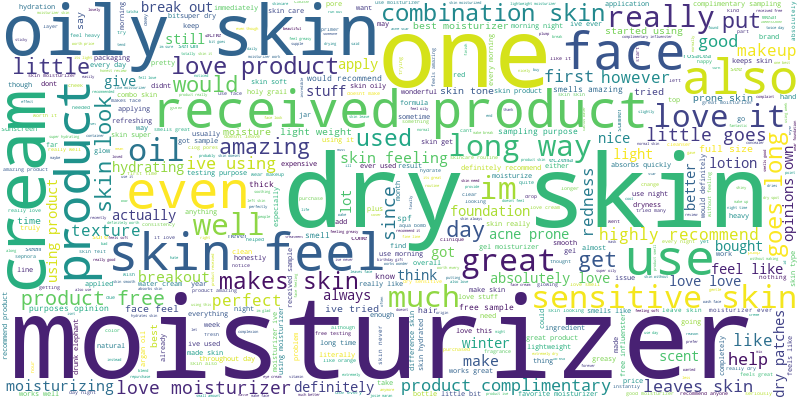

In [73]:
positive_reviews = users[users['is_positive'] == 1]
positives = " ".join([" ".join(review) for review in positive_reviews['review']])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3,  width=800, height=400, stopwords=stops)

# Generate a word cloud
wordcloud.generate(positives)

# Visualize the word cloud
wordcloud.to_image()

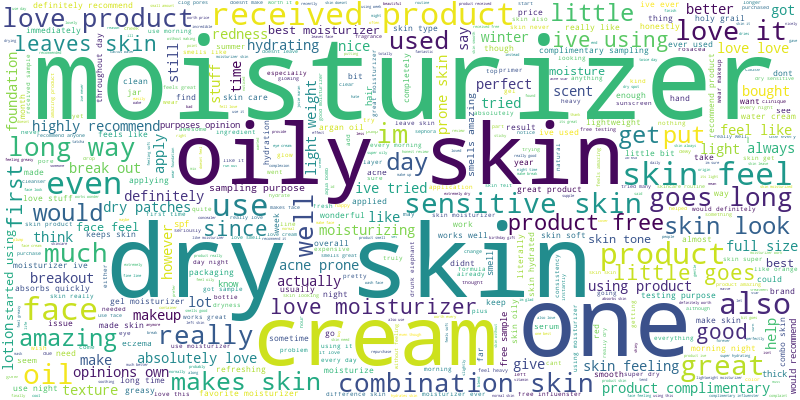

In [78]:
# Wordcloud for those with flagged skin conditions
condition_flag = users[(users['flag_skin_condition'])== 1 & (users['is_positive'] == 1)]
condition = " ".join([" ".join(review) for review in positive_reviews['review']])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3,  width=800, height=400, stopwords=stops)

# Generate a word cloud
wordcloud.generate(condition)

# Visualize the word cloud
wordcloud.to_image()

In [51]:
# Write to csv file
items.to_csv('data/items_final.csv')
users.to_csv('data/user_final.csv')
chemicals.to_csv('data/chemical_effects_final.csv')